In [2]:
import os

PROJECT_ROOT = os.path.abspath("..")
os.chdir(PROJECT_ROOT)

print("Directorio de trabajo:", os.getcwd())


Directorio de trabajo: /home/diego/Escritorio/GEOLABANTES/Lab2DV


In [3]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt

# Rutas
RAW_DIR = "data/raw"
OUT_RASTER_DIR = "data/processed"
OUT_FIG_DIR = "outputs/figures"

os.makedirs(OUT_RASTER_DIR, exist_ok=True)
os.makedirs(OUT_FIG_DIR, exist_ok=True)

# Años a procesar
years = [2017, 2019, 2021, 2024]

def safe_divide(a, b):
    return np.where(b == 0, np.nan, a / b)

for year in years:
    path = os.path.join(RAW_DIR, f"sentinel2_pudahuel_{year}.tif")
    if not os.path.exists(path):
        print(f"Archivo no encontrado para {year}, se omite.")
        continue

    print(f"Procesando {year}...")

    with rasterio.open(path) as src:
        blue  = src.read(1).astype("float32")   # B2
        green = src.read(2).astype("float32")   # B3
        red   = src.read(3).astype("float32")   # B4
        nir   = src.read(4).astype("float32")   # B8
        swir1 = src.read(5).astype("float32")   # B11
        swir2 = src.read(6).astype("float32")   # B12

        meta = src.meta.copy()
        meta.update(count=1, dtype="float32")

    # Índices espectrales
    ndvi = safe_divide(nir - red, nir + red)
    ndbi = safe_divide(swir1 - nir, swir1 + nir)
    ndwi = safe_divide(green - nir, green + nir)
    bsi  = safe_divide((swir1 + red) - (nir + blue),
                       (swir1 + red) + (nir + blue))

    indices = {
        "NDVI": ndvi,
        "NDBI": ndbi,
        "NDWI": ndwi,
        "BSI":  bsi
    }

    # Guardar rasters e imágenes
    for name, data in indices.items():
        raster_out = os.path.join(
            OUT_RASTER_DIR, f"{name.lower()}_pudahuel_{year}.tif"
        )

        with rasterio.open(raster_out, "w", **meta) as dst:
            dst.write(data, 1)

        # Mapa PNG para informe
        plt.figure(figsize=(6, 5))
        plt.imshow(data, cmap="RdYlGn")
        plt.colorbar(label=name)
        plt.title(f"{name} - Pudahuel {year}")
        plt.axis("off")

        fig_out = os.path.join(
            OUT_FIG_DIR, f"{name.lower()}_pudahuel_{year}.png"
        )
        plt.savefig(fig_out, dpi=200, bbox_inches="tight")
        plt.close()

    print(f"Índices calculados para {year}")

print("Proceso finalizado.")


Procesando 2017...
Índices calculados para 2017
Procesando 2019...
Índices calculados para 2019
Procesando 2021...
Índices calculados para 2021
Procesando 2024...
Índices calculados para 2024
Proceso finalizado.


In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

IN_DIR = "data/processed"
OUT_DIR = "outputs/figures"
os.makedirs(OUT_DIR, exist_ok=True)

def read_raster(path):
    with rasterio.open(path) as src:
        data = src.read(1)
        meta = src.meta
    return data, meta

# Cargar índices
ndvi_2017, meta = read_raster(os.path.join(IN_DIR, "ndvi_pudahuel_2017.tif"))
ndvi_2024, _    = read_raster(os.path.join(IN_DIR, "ndvi_pudahuel_2024.tif"))

ndbi_2017, _ = read_raster(os.path.join(IN_DIR, "ndbi_pudahuel_2017.tif"))
ndbi_2024, _ = read_raster(os.path.join(IN_DIR, "ndbi_pudahuel_2024.tif"))

# Diferencias
delta_ndvi = ndvi_2024 - ndvi_2017
delta_ndbi = ndbi_2024 - ndbi_2017


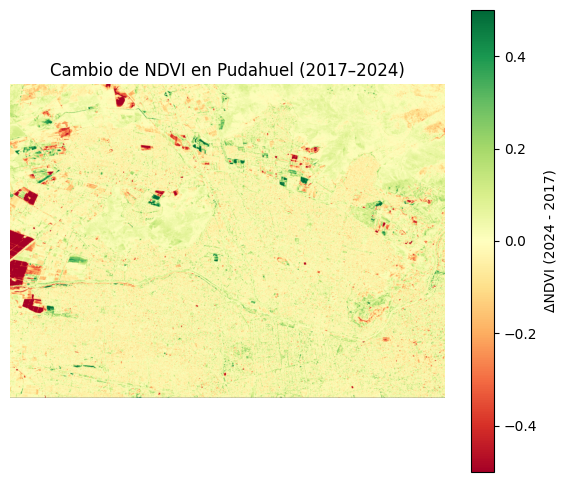

In [5]:
plt.figure(figsize=(7,6))
plt.imshow(delta_ndvi, cmap="RdYlGn", vmin=-0.5, vmax=0.5)
plt.colorbar(label="ΔNDVI (2024 - 2017)")
plt.title("Cambio de NDVI en Pudahuel (2017–2024)")
plt.axis("off")
plt.savefig("outputs/figures/delta_ndvi_2017_2024.png", dpi=200, bbox_inches="tight")
plt.show()


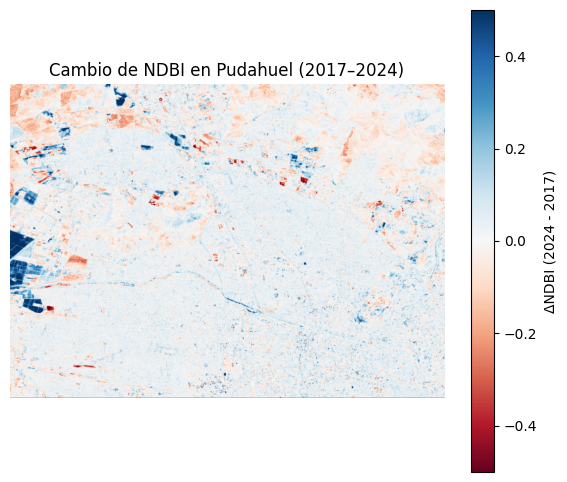

In [6]:
plt.figure(figsize=(7,6))
plt.imshow(delta_ndbi, cmap="RdBu", vmin=-0.5, vmax=0.5)
plt.colorbar(label="ΔNDBI (2024 - 2017)")
plt.title("Cambio de NDBI en Pudahuel (2017–2024)")
plt.axis("off")
plt.savefig("outputs/figures/delta_ndbi_2017_2024.png", dpi=200, bbox_inches="tight")
plt.show()


In [7]:
# Umbrales simples (justificados)
ndvi_loss = delta_ndvi < -0.2
ndbi_gain = delta_ndbi > 0.2

total_pixels = np.isfinite(delta_ndvi).sum()

pct_ndvi_loss = ndvi_loss.sum() / total_pixels * 100
pct_ndbi_gain = ndbi_gain.sum() / total_pixels * 100

print(f"Pérdida significativa de vegetación: {pct_ndvi_loss:.2f}% del área")
print(f"Aumento significativo de áreas construidas: {pct_ndbi_gain:.2f}% del área")


Pérdida significativa de vegetación: 2.33% del área
Aumento significativo de áreas construidas: 2.70% del área


In [8]:
meta.update(dtype="float32", count=1)

with rasterio.open("data/processed/delta_ndvi_2017_2024.tif", "w", **meta) as dst:
    dst.write(delta_ndvi.astype("float32"), 1)

with rasterio.open("data/processed/delta_ndbi_2017_2024.tif", "w", **meta) as dst:
    dst.write(delta_ndbi.astype("float32"), 1)


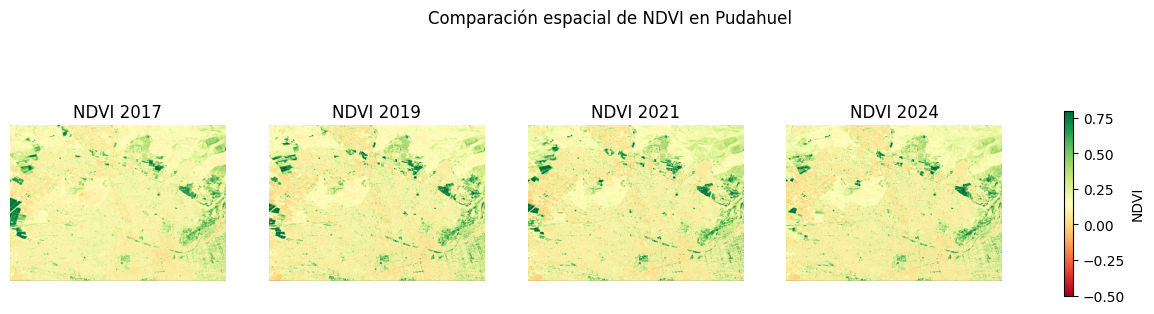

In [10]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

years = [2017, 2019, 2021, 2024]

fig, axes = plt.subplots(1, 4, figsize=(16,4), sharey=True)

for i, year in enumerate(years):
    with rasterio.open(f"data/processed/ndvi_pudahuel_{year}.tif") as src:
        ndvi = src.read(1)

    im = axes[i].imshow(ndvi, cmap="RdYlGn", vmin=-0.5, vmax=0.8)
    axes[i].set_title(f"NDVI {year}")
    axes[i].axis("off")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="NDVI")
plt.suptitle("Comparación espacial de NDVI en Pudahuel")
plt.savefig("outputs/figures/ndvi_comparativo.png", dpi=200, bbox_inches="tight")
plt.show()


In [11]:
import pandas as pd

stats = []

for year in years:
    with rasterio.open(f"data/processed/ndvi_pudahuel_{year}.tif") as src:
        ndvi = src.read(1)
        ndvi = ndvi[np.isfinite(ndvi)]

    stats.append({
        "Año": year,
        "Media NDVI": ndvi.mean(),
        "Std NDVI": ndvi.std()
    })

df_stats = pd.DataFrame(stats)
df_stats


,Año,Media NDVI,Std NDVI
0,2017,0.184632,0.136641
1,2019,0.183654,0.152566
2,2021,0.187591,0.153449
3,2024,0.182532,0.145649


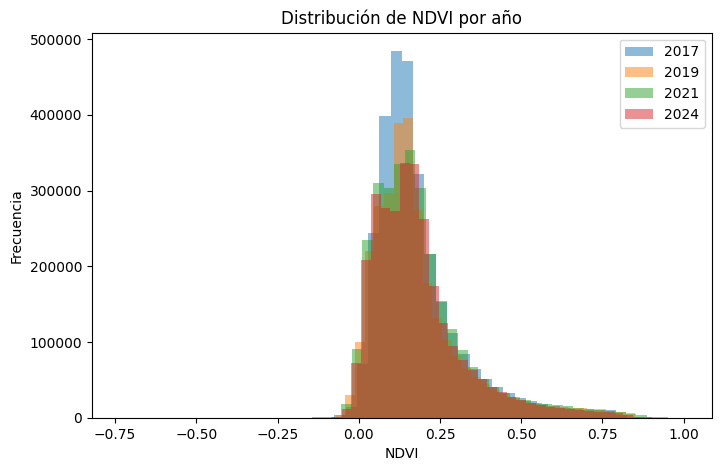

In [12]:
plt.figure(figsize=(8,5))

for year in years:
    with rasterio.open(f"data/processed/ndvi_pudahuel_{year}.tif") as src:
        ndvi = src.read(1)
        ndvi = ndvi[np.isfinite(ndvi)]

    plt.hist(ndvi, bins=50, alpha=0.5, label=str(year))

plt.xlabel("NDVI")
plt.ylabel("Frecuencia")
plt.legend()
plt.title("Distribución de NDVI por año")
plt.savefig("outputs/figures/histograma_ndvi.png", dpi=200, bbox_inches="tight")
plt.show()


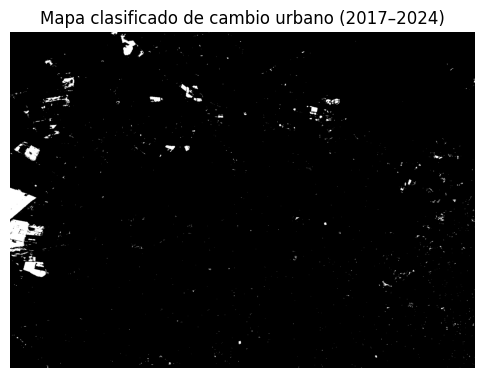

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Clasificación simple
cambio_urbano = (delta_ndbi > 0.2) & (delta_ndvi < -0.2)

plt.figure(figsize=(6,6))
plt.imshow(cambio_urbano, cmap="gray")
plt.title("Mapa clasificado de cambio urbano (2017–2024)")
plt.axis("off")
plt.savefig("outputs/figures/mapa_cambio_clasificado.png", dpi=200, bbox_inches="tight")
plt.show()
